## QAOA MAXCLIQUE

In [1]:
%matplotlib inline
# useful additional packages 

import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.visualization import plot_histogram, plot_state_city
import random
from itertools import product
from tqdm import tqdm
from collections import deque, namedtuple


### Classical Solution

For binary variables $Z_i = \pm 1$ in a graph $G$ with $C(G)$ its complementary graph. We want 1 for edges belonging to a maxclique and 0 otherwise. To obtain a maxclique of $-1$ variables corresponding to $|1>$ states the Hamiltonian to minimize is
$$
H_{MaxC} = H_0 + H_1 = +\sum_{i \in G} Z_i + \omega \sum_{a,b \in C(G)} Z_a Z_b - Z_a -Z_b
$$
The term $H_0$ maximises the number of $-1$ variables <br>
The term $H_1$ makes sure that if two variables are not connected in G they are not in the combination (-1,-1). In fact

- $H_1(1,1) = H_1(-1,1) = H_1(1,-1) = -\omega$
- $H_1(-1,-1) = +3\omega$

That is, maximizing the independent set in complementary graph.

### Quantum Circuit

We apply:

- Prepare state: Hadamard gate on every qubit
- Evolution: apply $e^{-i\gamma H_{MaxC}} = e^{i\gamma \sum_{i \in G} Z_i } \prod_{a,b \in C(G)} e^{-i \gamma \omega Z_a Z_b} e^{+i\gamma \omega Z_a} e^{+i\gamma \omega Z_b}$ where $e^{-i \gamma \omega Z_a Z_b} = CNOT(a, b)R_z(\omega \gamma , b)CNOT(a,b)$ and $e^{+i\gamma \omega Z} = R_z (-2\gamma \omega) = [e^{i\gamma \omega}, 0, 0, e^{-i \gamma \omega}]$ bc $R_z (\lambda) = [e^{-i\lambda/2}, 0, 0, e^{i \lambda/2}]$
- Mixing: apply $e^{-i\beta \sum X}$
- Measurement

### QAOA

In [44]:
def create_graph(n, prob_conn, M = 0):
    '''
    Creates a graph of N edges with a probablity of connectivity of each edge: prob_conn
    M decides the maxclique:
        if M is 0 the maxclique will be randomly generated
        if M>0 there will be a maxclique of at least M
    '''
    
    if prob_conn > 1:
        raise ValueError("Prob needs to be lower than 1")
    N = n
    print(N)
    prob_connectivity = prob_conn
    V   = np.arange(0,n,1)
    E = []
    
    #Creates generic graph with at least one connection per every vertex
    for i in range(n):
        one_edge_minimum = False
        for j in range(n):
            if i!=j and (j,i,1.0) not in E and np.random.rand()<prob_connectivity:
                E.append((i,j, 1.0))
                one_edge_minimum = True
        if not one_edge_minimum:
            choose = np.ones(n)/(n-1)
            choose[i] = 0
            E.append((i, np.random.choice(range(n), p = choose), 1))
    
    #Makes sure there is at least a M-large clique
    if M>0:
        max_clique = random.sample(range(0, n), M)
        for i in max_clique:
            for j in max_clique:
                if i!=j and ((j,i,1.0) not in E) and ((i,j,1.0) not in E):
                    E.append((i,j,1.0))
    G = nx.Graph()
    G_comp = nx.Graph()
    G.add_nodes_from(V)
    G.add_weighted_edges_from(E)
    G_comp = nx.complement(G)  
    
    return G

def create_graph_specific(graph_type):
    '''
    Creates preset graphs decided by graph-type:
    graph-type:
        -- simple7: a simple 7 vertex graph with a 4 max clique
        -- simple4: a simple 4 vertex graph with a 3 max clique
        -- simple5: a simple 5 vertex graph with a 3 max clique
    '''
    if graph_type == 'simple7':
        N=7
        V   = np.arange(0,N,1)
        E = []
        E     =[(0,1,1.0),(0,2,1.0),(0,3,1),(1,2,1.0),(1,3,1),(3,2,1.0),(3,4,1.0),(2,5,1.0), (2,6,1)] 
    if graph_type == 'simple4':
        N=4
        V   = np.arange(0,N,1)
        E = []
        E     =[(0,1,1.0),(0,2,1.0),(1,2,1),(2,3,1.0)] 
        
    if graph_type == 'simple5':   
        N   = 5
        V   = np.arange(0,N,1)
        E = [(0,1,1), (1,2,1), (0,2,1), (2,3,1), (3,4,1)]
    
    if graph_type == 'simple6':
        N=6
        V   = np.arange(0,N,1)
        E = []
        E     = [(0, 2, 1), (0, 1, 1), (1, 4, 1), (1, 2, 1), (1, 3, 1), (2, 4, 1)]
        
    if graph_type == 'chair':
        N = 6
        V = np.arange(0, N, 1)
        E = []
        E = [(0,3), (0,4), (0,5), (1, 2), (1,4), (1,5), (2,4), (2,5), (4,5)]
                   
    G = nx.Graph()
    G_comp = nx.Graph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    G_comp = nx.complement(G)     
    
    return G, G_comp

def draw_graph(G, comp = False):
    '''
    Draws given graph G and its complement G if comp = True
    '''
    if comp:
        G_complement = nx.complement(G)
        fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
    else:
        fig, axis = plt.subplots(111, figsize = (4,4))
    
    colors       = ['r' for node in G.nodes()]
    default_axes = axis[0]
    pos          = nx.circular_layout(G)
    axis[0].set_title('Graph')
    first_graph = nx.draw_networkx(G, node_color=colors, node_size=200, alpha=1, ax=default_axes, pos=pos)
    
    if comp:
        colors       = ['b' for node in G_complement.nodes()]
        default_axes = axis[1]
        pos          = nx.circular_layout(G_complement)
        axis[1].set_title('Complementary Graph')
        nx.draw_networkx(G_complement, node_color=colors, node_size=200, alpha=1, ax=default_axes, pos=pos)

def cost_function(values):
    '''
    Evaluates cost of the +1/-1 combination of spins
    '''
    configuration = 1 - 2*values
    cost = -(len(configuration) - sum(configuration))/2 
    for edge in G_comp.edges:
        cost += omega/4*(1-configuration[edge[0]])*(1-configuration[edge[1]])
    return cost


def classical_solution():    
    '''
    Runs through all 2^n possible configurations and estimates how many max cliques there are and plots one
    '''
    
    #Evaluate for every possible configuration
    lst = list(itertools.product([0, 1], repeat=len(G)))
    results = {}
    for i in tqdm(range(2**len(G))):
        results[lst[i]] = cost_function(np.array(lst[i]))
    
    print('All possible solutions: \n')
    sol = np.unique(list(results.values()), return_counts = True)
    print(sol[0])
    print(sol[1])
    d = dict((k, v) for k, v in results.items() if v == np.min(list(results.values())))
    print('There are {} MAXCLIQUE(S) with energy: \n'.format(len(d)), d)
    
    fig = plt.figure(figsize=(6, 6))
    val, counts = np.unique(list(results.values()), return_counts = True)
    plt.bar(val, counts)
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Statistics of solutions')

    #PLot one of the largest cliques
    fig = plt.figure(figsize = (4,4))
    plt.title('MaxClique')
    colors       = list(d.keys())[0]
    pos          = nx.circular_layout(G)
    nx.draw_networkx(G, node_color=colors, node_size=200, alpha=1, pos=pos)
    
    return d

def quantum_algorithm(gamma, beta):
    qc = QuantumCircuit(N,N)

    #prepare state
    qc.h(range(N))

    for edge in G_comp.edges: 
        qc.rzz(gamma*omega/2, edge[0], edge[1])
        qc.rz(-gamma*omega/2, edge[0]) 
        qc.rz(-gamma*omega/2, edge[1]) 
        
    for i in G.nodes:
        qc.rz(gamma, i) 
        
    qc.rx(2*beta, range(N)) 
    
    meas = QuantumCircuit(N,N)
    meas.barrier(range(N))
    meas.measure(range(N), range(N))

    return qc + meas

def QAOA(params):
    '''
    Applies QAOA
    '''
    gamma = params[0]
    beta = params[1]
    
    backend= Aer.get_backend("qasm_simulator")
    qc = quantum_algorithm(gamma, beta)
    simulate     = execute(qc, backend=backend, shots=shots)
    results = simulate.result()
    extimated_f1 = 0
    counts = results.get_counts()
    pretty_counts = {k[::-1]:v for k,v in counts.items()} 
    for combination in pretty_counts:
        comb_to_extimate = np.array([int(x) for x in combination])
        extimated_f1 += cost_function(comb_to_extimate)*pretty_counts[combination]/shots 
    return extimated_f1, pretty_counts

def grid_search(num_params, param_range = np.pi, show_plot=True):

    QAOA_results = []
    Point = namedtuple("Point", "gamma beta f1")
    lin = np.linspace(0, param_range, num_params)
    params = np.array(list((product(lin, repeat = 2))))
    
    X = np.unique(params[:,0])
    Y = np.unique(params[:,1])
    X, Y = np.meshgrid(X, Y)
    Q = np.zeros((len(X),len(X)))
    
    for i,j in tqdm(list(product(range(len(X)),repeat=2))):
        Q[i,j], _ = QAOA([X[i,j],Y[i,j]])
    
    if show_plot:

        plt.imshow(Q, extent = [0, param_range, param_range, 0])
        plt.title('Grid Search: [{} x {}]'.format(len(X), len(X)))
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)

        cb = plt.colorbar()
        plt.xlabel(r'$\gamma$', fontsize=20)
        plt.ylabel(r'$\beta$', fontsize =20)
        cb.ax.tick_params(labelsize=15)
        
        points = [Point(*x) for x in np.dstack((X,Y,Q)).reshape(-1,3)]
        
        return points

def plot_distribution(C):
    mpl.rc('text', usetex = False)
    #mpl.rc('font', family = 'serif')

    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: 'g' for key in C}
    #indexes = ['01011', '00111']  # MIS indexes
    #for i in indexes:
    #   color_dict[i] = 'red'
    plt.figure(figsize=(12,6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color = color_dict.values())
    plt.xticks(rotation='vertical')
    plt.show()

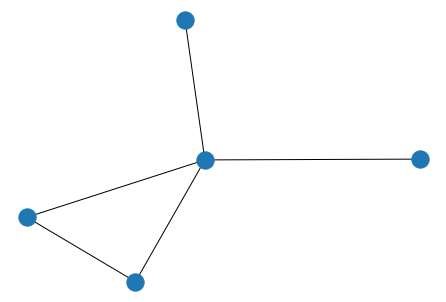

In [3]:
omega = 2
shots = 1000
depth = 1

E = []
#N = 6
#V = np.arange(0, N, 1)
#E = [(0,3), (0,4), (0,5), (1, 2), (1,4), (1,5), (2,4), (2,5), (4,5)]

N = 5
V = np.arange(0, N, 1)
E = [(0,1), (1,2), (0,2), (2,3), (2,4)]

G = nx.Graph()
G_comp = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)
G_comp = nx.complement(G)  
nx.draw(G)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 84.27it/s]


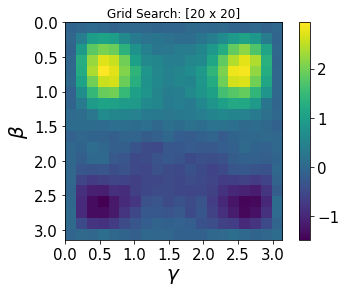

In [45]:
para = grid_search(20)

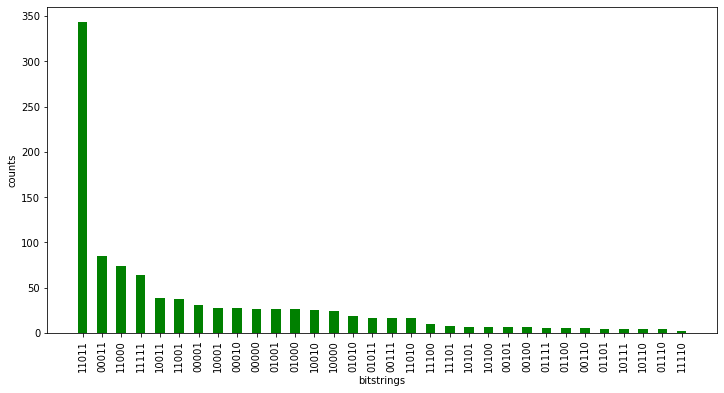

9.789999999999997


In [5]:
f1, counts = QAOA([0.785,0.785])
plot_distribution(counts)
print(f1)

In [34]:
h = .01
threshold = .001
np.random.seed(9320)
#params = np.random.uniform(0, np.pi, 2*depth)
params = [1.5, 1.5]
dparams = np.zeros(2*depth)
eta = .005

#ADAM parameters
ADAM = False
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
m_t = 0
v_t = 0
t = 0

count = 0
training_params = []
list_f1 = []
training_params.append(params)
list_f1.append(f1)
running_f1 = deque([f1])

save_params = []
print('Iter   |  gamma  | beta   |  Energy  |  delta\n')
while True:
    for i in range(depth):
        variation = np.zeros(2*depth)
        variation[i] = h
        incr, _ = QAOA(params + variation)
        decr, _ = QAOA(params - variation)
        Delta_f = incr - decr
        
        t += 1
        m_t = beta_1*m_t + (1-beta_1)*Delta_f
        v_t = beta_2*v_t + (1-beta_2)*Delta_f**2
        m_t_hat = m_t/(1-beta_1**t)
        v_t_hat = v_t/(1-beta_2**t)
        if ADAM:
            dparams[i] = m_t_hat/(np.sqrt(v_t_hat) + epsilon)
        dparams[i] = (Delta_f)/(2*h)

        variation[depth + i] = h
        incr, _ = QAOA(params + variation)
        decr, _ = QAOA(params - variation)
        Delta_f = incr - decr
        
        m_t = beta_1*m_t + (1-beta_1)*Delta_f
        v_t = beta_2*v_t + (1-beta_2)*Delta_f**2
        m_t_hat = m_t/(1-beta_1**t)
        v_t_hat = v_t/(1-beta_2**t)
        if ADAM:
            dparams[i] = m_t_hat/(np.sqrt(v_t_hat) + epsilon)
        dparams[depth + i] = (incr - decr)/(2*h)
    
    params = params - dparams * eta

    count+=1
    current_f1, _ = QAOA(params)
    training_params.append(params)
    list_f1.append(current_f1)
    
    if count<=10:
        running_f1.append(current_f1)
        variance = 0
    if count>10:
        running_f1.popleft()
        running_f1.append(current_f1)
        variance = np.var(running_f1)
        #if variance <.00005:
         #   print('found min')
          #  break
    
    print(count, training_params[-1], list_f1[-1], dparams*eta)
    #print(' {}   {:.5f}   {:.5f}   {:.3f}'.format(count, training_betas[-1], training_gammas[-1], list_f1[-1]), flush=True)
  
    if np.sum(np.abs(dparams*eta) < 1e-4) == 2:
        print('Converged bc params are varying in the order 1e-4 < threshold')
        break
    
    if count == 500:
        flag = False
        print('STOP AT 500 STEPS')
        break

Iter   |  gamma  | beta   |  Energy  |  delta

1 [1.4725 1.4095] 0.06399999999999986 [0.0275 0.0905]
2 [1.3505 1.682 ] -0.3240000000000004 [ 0.122  -0.2725]
3 [1.5265 1.6965] 0.22399999999999998 [-0.176  -0.0145]
4 [1.6475 1.7595] -0.678 [-0.121 -0.063]
5 [1.7015 1.734 ] -0.25199999999999967 [-0.054   0.0255]
6 [1.7385 1.6095] -0.22799999999999992 [-0.037   0.1245]
7 [1.4495 1.7065] 0.3839999999999994 [ 0.289 -0.097]
8 [1.195 1.649] -0.8340000000000001 [0.2545 0.0575]
9 [1.197  1.4745] 0.814 [-0.002   0.1745]
10 [1.2785 1.3915] 0.6260000000000001 [-0.0815  0.083 ]
11 [1.2275 1.524 ] 0.7260000000000005 [ 0.051  -0.1325]
12 [1.4455 1.4825] 0.3600000000000001 [-0.218   0.0415]
13 [1.1425 1.62  ] -0.5860000000000001 [ 0.303  -0.1375]
14 [1.083  1.6485] -0.462 [ 0.0595 -0.0285]
15 [1.1615 1.78  ] -1.144 [-0.0785 -0.1315]
16 [1.159  1.7415] -0.364 [0.0025 0.0385]
17 [1.264 1.815] -1.028 [-0.105  -0.0735]
18 [1.267  1.7095] -0.622 [-0.003   0.1055]
19 [1.3135 1.7065] 0.4559999999999991 [-0.04

163 [0.268 2.794] -5.376 [ 0.0215 -0.032 ]
164 [0.318 2.799] -6.0600000000000005 [-0.05  -0.005]
165 [0.3405 2.905 ] -5.124000000000001 [-0.0225 -0.106 ]
166 [0.351 2.993] -3.5360000000000005 [-0.0105 -0.088 ]
167 [0.272  2.9515] -3.6319999999999992 [0.079  0.0415]
168 [0.352 2.782] -6.340000000000001 [-0.08    0.1695]
169 [0.4385 2.7425] -6.784000000000001 [-0.0865  0.0395]
170 [0.4905 2.727 ] -6.655999999999999 [-0.052   0.0155]
171 [0.432 2.7  ] -6.602 [0.0585 0.027 ]
172 [0.458 2.72 ] -6.698 [-0.026 -0.02 ]
173 [0.4755 2.6555] -7.1339999999999995 [-0.0175  0.0645]
174 [0.52   2.6495] -6.5920000000000005 [-0.0445  0.006 ]
175 [0.4425 2.645 ] -6.838 [0.0775 0.0045]
176 [0.499  2.6285] -6.4319999999999995 [-0.0565  0.0165]
177 [0.421  2.5925] -6.554 [0.078 0.036]
178 [0.4035 2.566 ] -6.274000000000001 [0.0175 0.0265]
179 [0.3935 2.6245] -6.646 [ 0.01   -0.0585]
180 [0.377  2.7045] -6.757999999999999 [ 0.0165 -0.08  ]
181 [0.325  2.7195] -6.3020000000000005 [ 0.052 -0.015]
182 [0.3405 

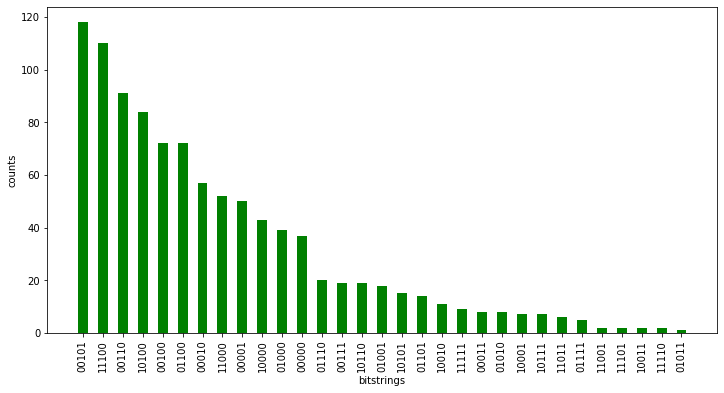

In [47]:
#classical_solution()

sol, counts = QAOA(params)

plot_distribution(counts)

In [39]:
bayesian_search = np.array(np.loadtxt('../data/raw/Bayes_search.dat'))
print(bayesian_search.shape)

(45, 2)


In [35]:
np.savetxt('../data/raw/FD_search.dat', training_params)

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:29<00:00, 84.18it/s]


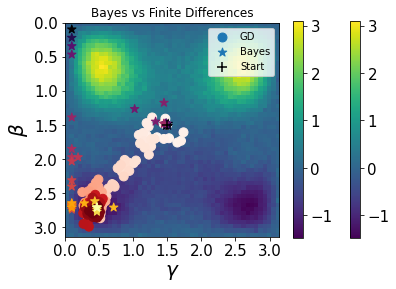

In [46]:
points = grid_search(50)
cb = plt.colorbar()
plt.title('Bayes vs Finite Differences')
#ticks = np.linspace(0, np.pi, len(X))[::4]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
training_params = np.array(training_params)
plt.scatter(training_params[:,0], training_params[:,1], 
            cmap = 'Reds', 
            c = range(len(training_params)),
            label = 'GD',
           s = 80)
plt.scatter(bayesian_search[:,0], bayesian_search[:,1], 
            cmap = 'inferno', marker = '*', 
            c = range(len(bayesian_search)),
           label = 'Bayes',
           s = 80)
plt.scatter(1.5,1.5, marker = '+',c = 'Black', s = 100, label = 'Start' )

plt.xlabel(r'$\gamma$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize =20)
plt.legend()
cb.ax.tick_params(labelsize=15)

In [29]:
fig = plt.figure()

# Make data.
X = np.unique(para[:,0])
Y = np.unique(para[:,1])
X, Y = np.meshgrid(X, Y)
Z = np.reshape(f1, (len(X), len(Y)))

# Plot the surface.
plt.imshow(Z, extent = [0, np.pi, np.pi, 0])
cb = plt.colorbar()
plt.title('Bayes vs Finite Differences'.format(len(X), len(X)))
#ticks = np.linspace(0, np.pi, len(X))[::4]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

training_params = np.array(training_params)
plt.scatter(training_params[:,0], training_params[:,1], 
            cmap = 'Reds', 
            c = range(len(training_params)),
            label = 'GD',
           s = 80)
plt.scatter(bayesian_search[:,0], bayesian_search[:,1], 
            cmap = 'inferno', marker = '*', 
            c = range(len(bayesian_search)),
           label = 'Bayes',
           s = 80)
plt.scatter(0.5,1.5, marker = '+',c = 'Black', s = 100, label = 'Start' )

plt.xlabel(r'$\gamma$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize =20)
plt.legend()
cb.ax.tick_params(labelsize=15)

TypeError: list indices must be integers or slices, not tuple

<Figure size 432x288 with 0 Axes>

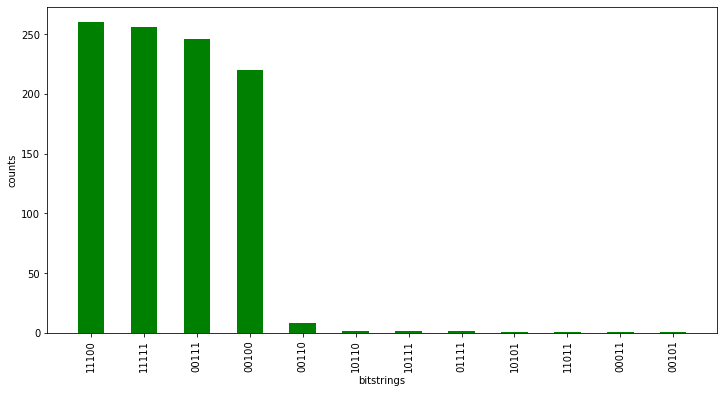

In [41]:
sol, counts = QAOA([2.37222302, 2.30810889])

plot_distribution(counts)